In [ ]:
directory = "/content/drive/MyDrive/496g"


In [ ]:
image_arrays = []
mask_arrays = []


In [ ]:
import os

image_filenames = sorted(os.listdir(os.path.join(directory, "images")))

import numpy as np
import PIL import image

for filename in image_filenames:
    if filename.endswith(".png"):
        image = np.array(Image.open(os.path.join(directory, "images", filename)))
        image_arrays.append(image)

In [ ]:

mask_filenames = sorted(os.listdir(os.path.join(directory, "masks")))

import cv2

for filename in mask_filenames:
    if filename.endswith(".png"):
        mask = np.array(Image.open(os.path.join(directory, "masks", filename)))
        mask = cv2.cvtColor(mask, 1)
        mask_arrays.append(mask)

In [ ]:

image_arrays = np.array(image_arrays)
mask_arrays = np.array(mask_arrays)



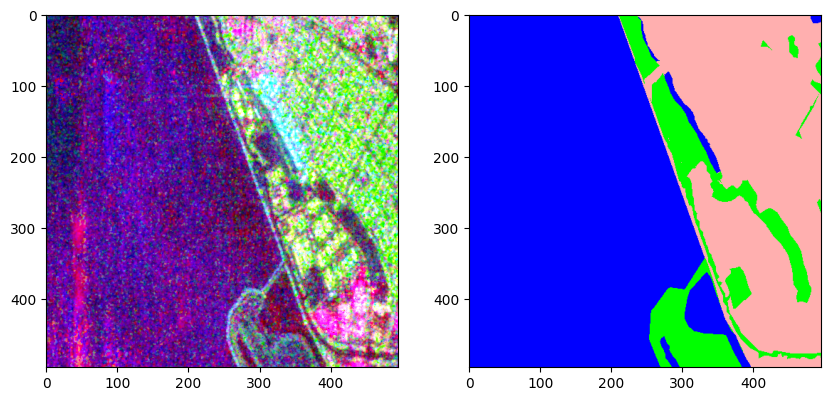

In [ ]:

import random
import numpy as np
image_number = random.randint(0, len(image_arrays))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_arrays[image_number])
plt.subplot(122)
plt.imshow(mask_arrays[image_number])
plt.show()


In [ ]:


forest = '#0f510d'
forest = np.array([int(forest[i:i+2], 16) for i in (1, 3, 5)])


vegetation = '#00ff00'
vegetation = np.array([int(vegetation[i:i+2], 16) for i in (1, 3, 5)])




urban = '#ffafaf'
urban= np.array([int(urban[i:i+2], 16) for i in (1, 3, 5)])



water= '#0000ff'
water = np.array([int(water[i:i+2], 16) for i in (1, 3, 5)])


label = mask




In [ ]:





def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == forest,axis=-1)] = 0
    label_seg [np.all(label==vegetation,axis=-1)] = 1
    label_seg [np.all(label==urban,axis=-1)] = 2
    label_seg [np.all(label==water,axis=-1)] = 3


    label_seg = label_seg[:,:,0]
    return label_seg





labels = []
for i in range(mask_arrays.shape[0]):
    label = rgb_to_2D_label(mask_arrays[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)



In [ ]:

labels = []
for i in range(mask_arrays.shape[0]):
    label = rgb_to_2D_label(mask_arrays[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


In [ ]:

print("Unique labels in label dataset are: ", np.unique(labels))



Unique labels in label dataset are:  [0 1 2 3]


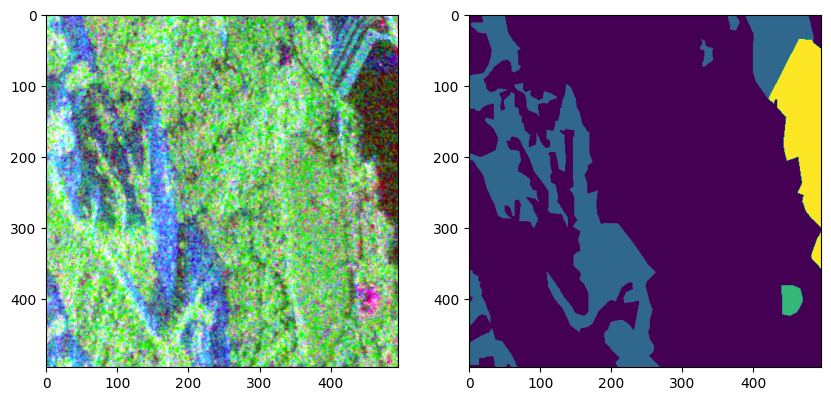

In [ ]:



import random
import numpy as np
image_number = random.randint(0, len(image_arrays))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_arrays[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [ ]:


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)



In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels_cat, test_size = 0.20, random_state = 42)



In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

weights = [0.25, 0.25, 0.25, 0.25]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [ ]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]





In [ ]:


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, add
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
def multi_linknet_model(n_classes=4, IMG_HEIGHT=496, IMG_WIDTH=496, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    s = inputs


    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)



    c5 = Conv2D(512,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.4)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)



    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = add([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = add([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = add([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)


    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = add([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)



    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])


    return model



In [ ]:

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_linknet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [ ]:

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 496, 496, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 496, 496, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 496, 496, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

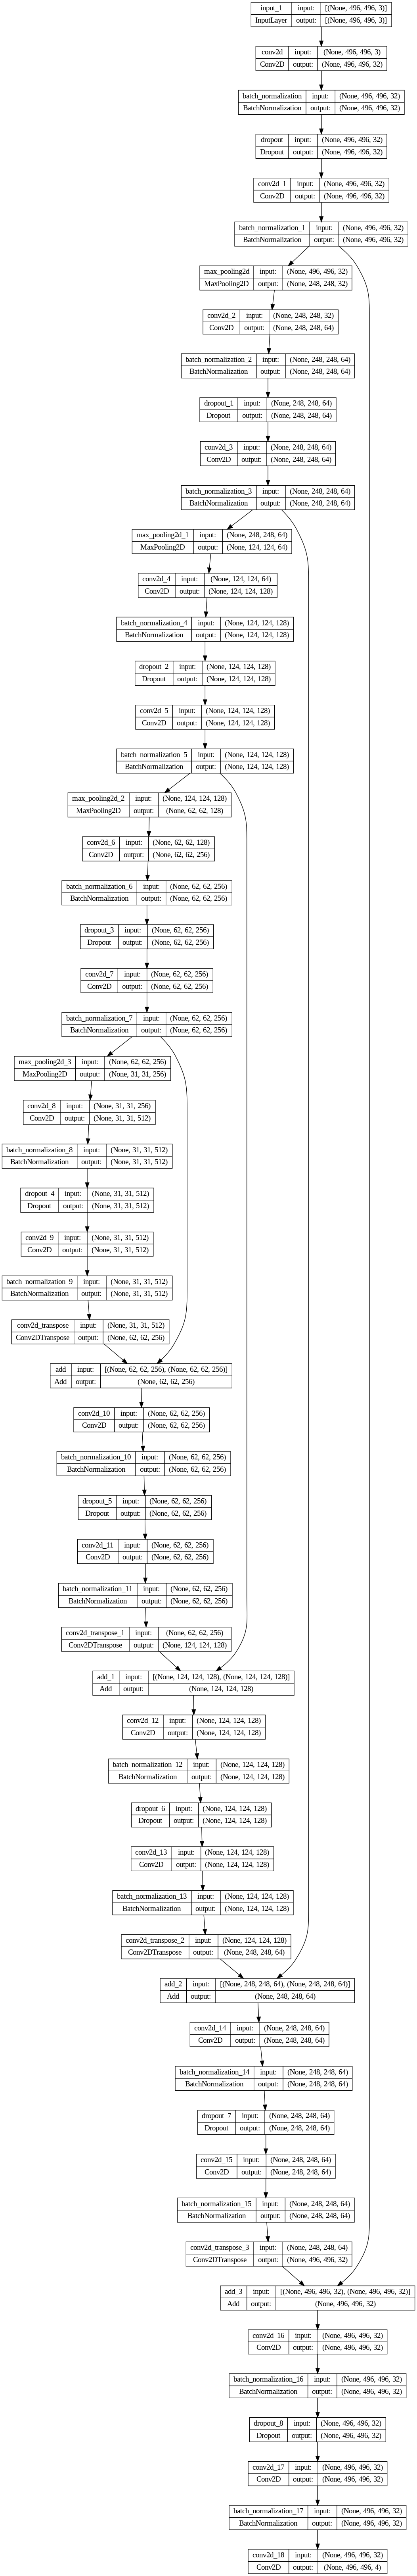

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file="unet_model.png",show_shapes=True,show_layer_names=True)

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=200,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/200
2/2 [==============================] - 47s 8s/step - loss: 1.0189 - accuracy: 0.2676 - jacard_coef: 0.1658 - val_loss: 1.5678 - val_accuracy: 0.2956 - val_jacard_coef: 0.1734
Epoch 2/200
2/2 [==============================] - 3s 1s/step - loss: 0.9424 - accuracy: 0.5261 - jacard_coef: 0.3001 - val_loss: 1.7051 - val_accuracy: 0.2709 - val_jacard_coef: 0.1567
Epoch 3/200
2/2 [==============================] - 3s 852ms/step - loss: 0.8952 - accuracy: 0.6945 - jacard_coef: 0.4264 - val_loss: 1.7084 - val_accuracy: 0.2704 - val_jacard_coef: 0.1563
Epoch 4/200
2/2 [==============================] - 3s 835ms/step - loss: 0.8654 - accuracy: 0.7883 - jacard_coef: 0.5272 - val_loss: 1.7084 - val_accuracy: 0.2704 - val_jacard_coef: 0.1563
Epoch 5/200
2/2 [==============================] - 3s 832ms/step - loss: 0.8465 - accuracy: 0.8391 - jacard_coef: 0.5955 - val_loss: 1.7084 - val_accuracy: 0.2704 - val_jacard_coef: 0.1563
Epoch 6/200
2/2 [==============================] - 3s 822ms/

In [ ]:

model.save('models/satellite_standard_linknet_with_500epochs496*496.hdf5')

In [ ]:

from keras.models import load_model
model = load_model("models/satellite_standard_linknet_with_500epochs496*496.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})




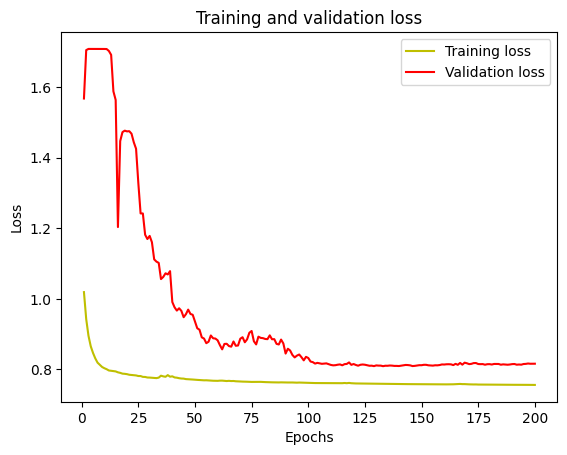

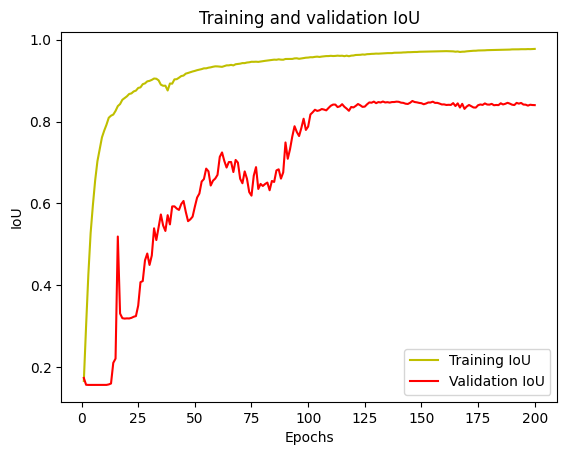

In [ ]:


history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:



y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)



from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 426ms/step
Mean IoU = 0.80560446


1/1 [==============================] - 1s 897ms/step


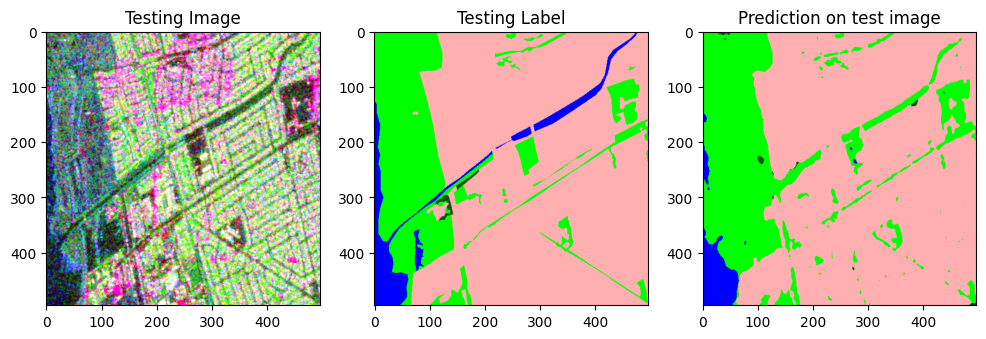

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]


colors = [
    '#0f510d',
    '#00ff00',
    '#ffafaf',
    '#0000ff'



rgb_colors = [mcolors.hex2color(color) for color in colors]


ground_truth_color = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)
for i in range(len(colors)):
    mask = (ground_truth == i)
    ground_truth_color[mask] = np.array(rgb_colors[i]) * 255


predicted_img_color = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)
for i in range(len(colors)):
    mask = (predicted_img == i)
    predicted_img_color[mask] = np.array(rgb_colors[i]) * 255

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_color)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img_color)
plt.show()


In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


accuracy = np.mean(y_pred_argmax == y_test_argmax)
print("Accuracy =", accuracy)


1/1 [==============================] - 0s 87ms/step
Accuracy = 0.9140137226847035
